In [2]:
import jax.numpy as jnp
import jax
import genjax
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
import rerun as rr
from tqdm import tqdm
from pathlib import Path

In [3]:
## Setup rerun
rr.init(f"projection")
rr.connect("127.0.0.1:8812")

[2024-04-17T23:58:37Z WARN  re_sdk_comms::buffered_client] Failed to send message after 3 attempts: Failed to connect to Rerun server at 127.0.0.1:8812: Connection refused (os error 111)
[2024-04-17T23:58:40Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-04-17T23:58:40Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-04-17T23:58:40Z WARN  re_sdk_comms::tcp_client] Tried to flush while TCP stream was still Pending. Data was possibly dropped.


In [4]:
# construct mesh
mesh = trimesh.Trimesh(vertices=[[-0.7, 0, 0], [0.1, -0.1, 0], [0, 0.5, 0]],
                       faces=[[0, 1, 2]],
                       process=False)

for facet in mesh.facets:
    mesh.visual.face_colors[facet] = trimesh.visual.random_color()
    
# load mesh  
_vertices = jnp.array(mesh.vertices) 
vertices = _vertices - _vertices.mean(0)
faces = jnp.array(mesh.faces)
vertex_colors = vertices * 0.0 + jnp.array([1.0, 0.0, 0.0])
vertex_colors = (jnp.array(mesh.visual.vertex_colors)[...,:3] / 255.0 ) 
ranges = jnp.array([[0, len(faces)]])

In [5]:
# normals
mesh.face_normals, mesh.face_normals.shape
mesh.vertex_normals # alternatively, interpolate the vertex normals

mesh_normals = mesh.face_normals  # face normals
mesh_normals

array([[-0., -0.,  1.]])

In [6]:
mesh_normals[0], jnp.linalg.norm(mesh_normals[0])

(array([-0., -0.,  1.]), Array(1., dtype=float32))

In [7]:
rr.log(
    "/3d/mesh",
    rr.Mesh3D(
        vertex_positions=vertices,
        indices=faces,
        vertex_colors=vertex_colors,
    ),
    timeless=False,
)


In [8]:
### SEt up renderer

image_width, image_height = 200,200
fx, fy, cx, cy, near, far = image_width*2, image_height*2, image_width/2, image_height/2, 0.01, 10.0
    
renderer = b3d.renderer.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)

# https://amytabb.com/tips/tutorials/2019/06/28/OpenCV-to-OpenGL-tutorial-essentials/#conversion-corner-1
"""This is NOT equivalent to just unprojecting point cloud from fx fy"""
def get_rc_from_xyz(vtx):  # assume vtx is already transformed
    K_gl = b3d.projection_matrix_from_intrinsics(image_width,image_height,fx,fy,cx,cy,near,far) # opengl proj matrix
    vtx = jnp.concatenate([vtx, jnp.ones((vtx.shape[0],1))],axis=-1) # world
    xyz = vtx.T
    ndc = (K_gl @ xyz)
    ndc = ndc / ndc[3]
    ndc_to_img = jnp.array([[image_width/2, 0, 0, image_width/2],
                     [0, image_height/2, 0, image_height/2],
                     [0, 0, 0, 1]])    
    x_gl = ndc_to_img @ ndc
   
    x = x_gl[0]
    y = x_gl[1]
    return y.astype(int), x.astype(int) # image row, column

In [9]:
CAM_ORIGIN = jnp.array([1e-6, -1e-6, 5.0])
ORIGIN = jnp.array([0,0,0])

In [10]:
camera_pose = Pose.from_position_and_target(
    CAM_ORIGIN,
    ORIGIN,
    up=jnp.array([0,1,0])
)
gt_pose = Pose.identity()

rr.log("/3d/camera/1", rr.Transform3D(translation=camera_pose.pos, mat3x3=camera_pose.rot.as_matrix()))
rr.log("/3d/camera/1/image", rr.Pinhole(focal_length=cx, width=image_width, height=image_height))

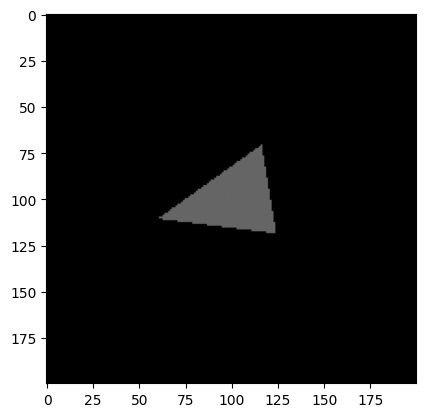

In [11]:
gt_img, gt_depth = renderer.render_attribute((camera_pose.inv() @ gt_pose)[None,...], 
                                            vertices, 
                                            faces, 
                                            ranges, 
                                            vertex_colors)
plt.imshow(gt_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


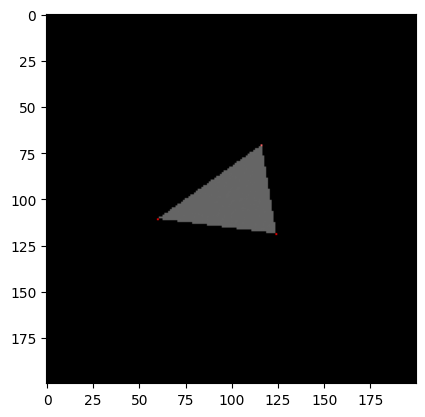

In [12]:
# check Opengl vtx - to - imgplane conversion
r,c = get_rc_from_xyz((camera_pose.inv() @ gt_pose).apply(vertices))
_img = np.array(gt_img)
for _r,_c in zip(r,c):
    _img[_r][_c][0] = 255.0
plt.imshow(_img)

#### now let's sample points on the triangle, and shoot rays from it

In [13]:
def sample_bary(n_sample=1):
    ## todo uniform sampling 
    key = jax.random.PRNGKey(0)
    alpha = jnp.array([1,1,1])  # uniform
    sample = jax.random.dirichlet(key, alpha, shape=(n_sample,))
    return sample

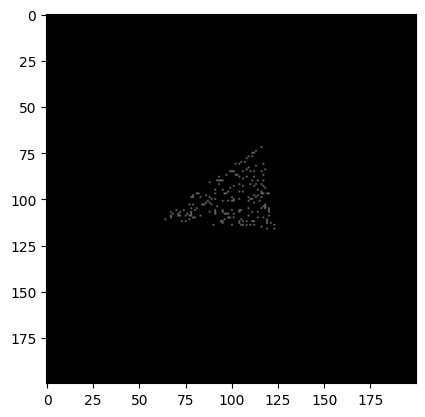

In [14]:
## barycentric coordinate to cartesian coordinate
get_cartesian_from_barycentric = lambda bary, tri_vertices: jnp.dot(bary, tri_vertices)

test_vertex_0 = get_cartesian_from_barycentric(sample_bary(200), vertices)  

center_r, center_c = get_rc_from_xyz((camera_pose.inv() @ gt_pose).apply(test_vertex_0))

_img = np.zeros_like(gt_img)
for _r,_c in zip(center_r,center_c):
    _img[_r][_c] = gt_img[_r,_c]
plt.imshow(_img)

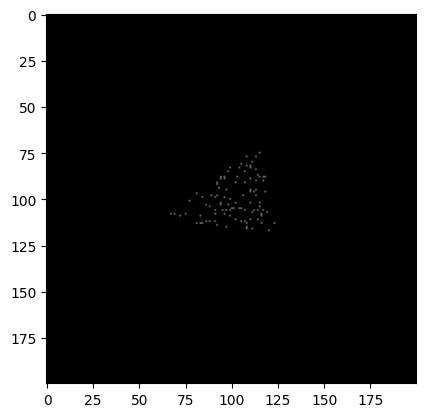

In [15]:
# cases in which point is NOT rendered to camera
def is_rendered(coord_on_tri, mesh_normals, tri_idx):
    point_to_cam = CAM_ORIGIN - coord_on_tri
    point_to_cam_dir = point_to_cam / jnp.linalg.norm(point_to_cam, axis=-1)[...,None]
    tri_normal = mesh_normals[tri_idx, :]
    # print("normal=",point_to_cam_dir.shape, tri_normal.shape)

    cos_theta = jnp.dot(point_to_cam_dir, tri_normal)
    return (cos_theta >= 0)

is_rendered(test_vertex_0, mesh_normals, 0)

@jax.tree_util.Partial(jax.jit, static_argnames=("k",))
def sample_and_render_triangle(k, vertices, faces, normals, tri_idx, rendered, img=None):
    # img
    if img is None:
        img = jnp.zeros((image_height, image_width,3))
    
    # get valid samples from triangle
    tri_verts = vertices[faces[tri_idx]]
    # print("tri_verts=", tri_verts.shape)
    _samples = get_cartesian_from_barycentric(sample_bary(k), tri_verts)  
    samples = samples=_samples#_samples[is_rendered(_samples, normals, tri_idx)]
    sample_pixels = get_rc_from_xyz(samples)
    # print("sample_pixels=", sample_pixels[0].shape)
    # get color/depth value at sample location
    img = img.at[sample_pixels].set(rendered[sample_pixels])   # TODO multiple ray same pixel?
    
    return img 

sampled_scene = sample_and_render_triangle(100, (camera_pose.inv() @ gt_pose).apply(vertices), faces, mesh_normals, 0, gt_img)
plt.imshow(sampled_scene)   



#### expanding to colored multi-triangle mesh + rendering scenes

In [16]:
bottle_mesh_path = Path(b3d.__file__).parents[1] / "assets/006_mustard_bottle/textured.obj"
bottle_mesh = trimesh.load(bottle_mesh_path)

bottle_vertices = jnp.array(bottle_mesh.vertices) * 20
bottle_vertices = bottle_vertices - bottle_vertices.mean(0)
bottle_faces = jnp.array(bottle_mesh.faces)
bottle_normals = bottle_mesh.face_normals
bottle_vertex_colors = jnp.array(bottle_mesh.visual.to_color().vertex_colors)[...,:3] / 255.0
bottle_ranges = jnp.array([[0, len(bottle_faces)]])

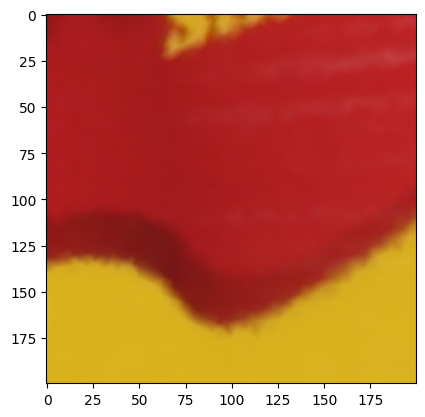

In [22]:
bottle_camera_pose = Pose.from_position_and_target(
    jnp.array([0.0, 1.0, 0.0]),
    ORIGIN,
    up=jnp.array([0,0,1])
)
bottle_img, bottle_depth = renderer.render_attribute((bottle_camera_pose.inv() @ gt_pose)[None,...], 
                                            bottle_vertices, 
                                            bottle_faces, 
                                            bottle_ranges, 
                                            bottle_vertex_colors)
plt.imshow(bottle_img) # zoomed up

Array([458934], dtype=int32)

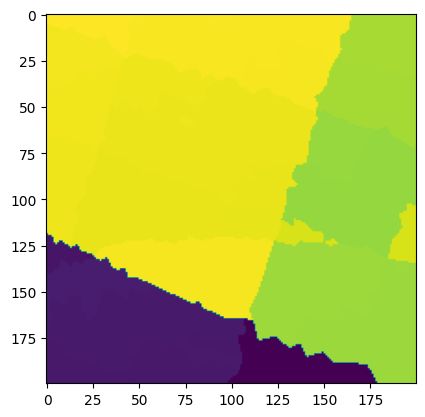

In [23]:
rast_ids = renderer.rasterize((bottle_camera_pose.inv() @ gt_pose)[None,...], 
                                bottle_vertices, 
                                bottle_faces, 
                                bottle_ranges)[2]
plt.imshow(rast_ids)
jnp.unique(rast_ids[75,75])

In [24]:
sampled_scene = None
bottle_vtx_xfm = (bottle_camera_pose.inv() @ gt_pose).apply(bottle_vertices)
for i in tqdm(jnp.unique(rast_ids)):
    sampled_scene = sample_and_render_triangle(1, bottle_vtx_xfm, bottle_faces, bottle_normals, i-1, bottle_img, sampled_scene)


100%|██████████| 3396/3396 [00:02<00:00, 1598.73it/s]


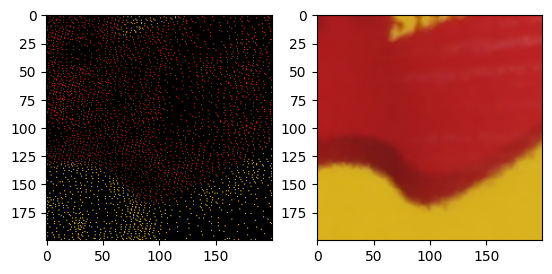

In [25]:
f, axes = plt.subplots(1,2)
axes[0].imshow(sampled_scene)
axes[1].imshow(bottle_img)